# Test the N^2 climatology

Test the fitted predictions against raw values

In [1]:
from iwatlas import sshdriver
from iwatlas import harmonics
import iwatlas.stratification as strat
from iwatlas import iwaves
from sfoda.utils.mynumpy import grad_z

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, RectBivariateSpline

import matplotlib.pyplot as plt

In [2]:
basedir = '/home/suntans/cloudstor/Data/IWAtlas'
sshfile = '{}/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'.format(basedir)
ampfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Amplitude_Atlas.nc'.format(basedir)
climfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'.format(basedir)
N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas_v2.1.nc'.format(basedir)

ds = sshdriver.load_ssh_clim(ampfile)
N2all = sshdriver.load_ssh_clim(N2file)
clim = sshdriver.load_ssh_clim(climfile)

ds, N2all

(<xarray.Dataset>
 Dimensions:   (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Ntide: 5, numsides: 8, time: 23)
 Coordinates:
     xv        (Nc) float64 ...
     yv        (Nc) float64 ...
     Nk        (Nc) int32 ...
   * time      (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
     z_w       (Nkw) float64 ...
 Dimensions without coordinates: Nc, Nkw, Nmode, Np, Ntide, numsides
 Data variables:
     cells     (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
     xp        (Np) float64 1.394e+07 1.271e+07 1.517e+07 ... 1.303e+07 1.303e+07
     yp        (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
     nfaces    (Nc) int32 ...
     dv        (Nc) float64 ...
     omega     (Ntide) float64 ...
     modes     (Nmode) float64 ...
     dz        (Nk) float64 ...
     z_r       (Nk) float64 ...
     cn        (time, Nmode, Nc) float64 ...
     alpha_n   (time, Nmode, Nc) float64 ...
     N2        (time, Nkw, Nc) float64 ...
     amp_b_re 

(<Figure size 864x432 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f6d80818ef0>)

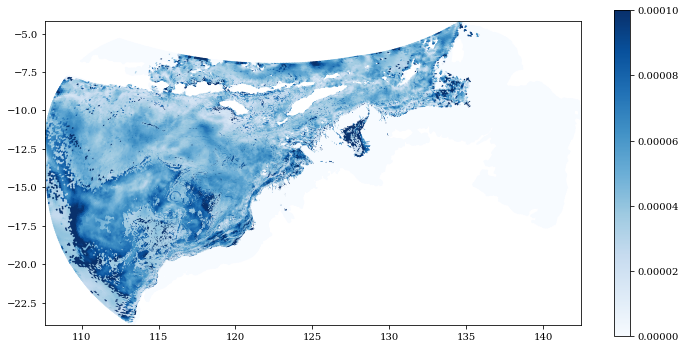

In [8]:
# Plot the error
plt.figure(figsize=(12,6))
N2all.plotcelldata(N2all._ds['N2_err'][11,:], vmax=1e-4, cmap='Blues')


In [ ]:
# xpt = 123.3506
# ypt = -13.7641
xpt, ypt = 123.43300000000035, -13.88594515688989

timept = clim._ds['time'].values
Nz = 80
density_func = getattr(strat, N2all._ds.attrs['density_func'] )

N2_z, zout = strat.predict_N2(N2file, np.array([xpt]) , np.array([ypt]), timept,  Nz, density_func=None)


In [11]:
_, idx = ds.find_nearest([ xpt, ypt])
nk = ds._ds['Nk'][idx].values

N2_ds = ds._ds['N2'][:,:,idx]

N2_ds

<xarray.DataArray 'N2' (time: 23, Nkw: 81)>
array([[1.000000e-09, 1.000000e-09, 1.000000e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e-09, 1.000000e-09, 4.281874e-08, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e-09, 1.000000e-09, 7.978439e-07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.000000e-09, 1.000000e-09, 9.603848e-07, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e-09, 1.000000e-09, 9.423170e-08, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.000000e-09, 1.000000e-09, 1.000000e-09, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])
Coordinates:
    xv       float64 ...
    yv       float64 ...
    Nk       int32 ...
  * time     (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    z_w      (Nkw) float64 ...
Dimensions without coordinates: Nkw
Attributes:
    long_name:  buoyancy frequency squared
    units:      s-2

(-236.24241808368248, 0)

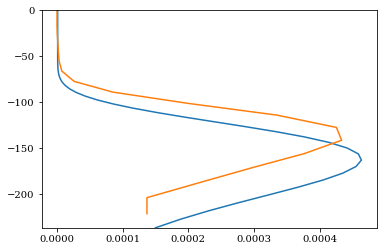

In [19]:
tstep = 0
plt.figure()
plt.plot(N2_z[:,0,tstep], -zout[:,0, tstep],)
plt.plot(N2_ds.values[tstep,0:nk], -N2_ds.z_w.values[0:nk], )
plt.ylim(-zout[-1,0,tstep],0)

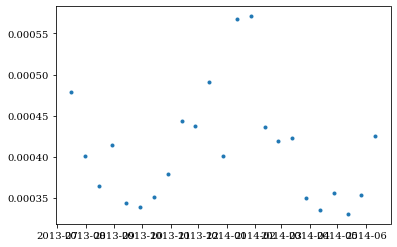

In [13]:
N2_t = N2all._ds['N2_t'][:,:,idx]

plt.figure()
plt.plot(N2_t['time'], N2_t[:,1],'.')

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


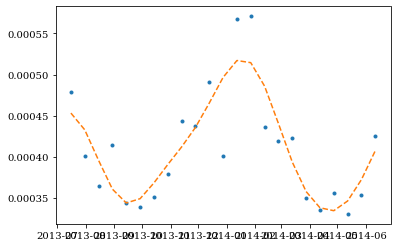

In [14]:
tsec = (N2_t['time'].values - np.datetime64('2000-01-01 00:00:00')).astype(float)*1e-9

param = 1

na = 4
aa, Aa, Ba, frq_all = strat.seasonal_harmonic_fit(N2_t[:,param].values, tsec, na)
N2_t_fit = strat.harmonic_pred_N2(aa, Aa, Ba, frq_all, tsec)

plt.figure()
plt.plot(N2_t['time'], N2_t[:,param],'.')
plt.plot(N2_t['time'], N2_t_fit.squeeze(),'--')

In [15]:
# Get the raw density
myrho = clim._ds['rho'][:,0:nk,idx]
myrho

z = ds._ds['z_r'].values[0:nk]

plt.figure()
plt.plot(cff*grad_z(myrho[tstep,:].values,-z),-z,'.')
plt.plot(N2_ds.values[tstep,0:nk], -N2_ds.z_w.values[0:nk],'.' )

myrho[tstep,:].values
cff = -9.81/1024
cff*grad_z(myrho[tstep,:].values,-z), myrho[tstep,:]

NameError: name 'cff' is not defined

<Figure size 432x288 with 0 Axes>

In [16]:
initguess = [1e-5,  1e-4, 4, 2, 4.5, 2]
# bounds = [ (1e-6, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 1e-1, 6, 6, 6, 6)]
bounds = [ (1e-7, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 1e-3, 6, 6, 6, 6)]

N2 = cff*grad_z(myrho[tstep,:].values,-z)

zpr = -np.log(z)
# zpr[0] = 0
N2std = 1# 2e-4

N2fit, N2params, err = strat.fit_rho_lsq(N2/N2std, zpr, strat.double_gaussian_N2,  bounds, initguess,)

plt.figure()
plt.plot(N2,-z,'.')
plt.plot(N2fit*N2std,-z,'r--')
print(N2params)


NameError: name 'cff' is not defined

(-15.7641, -11.7641)

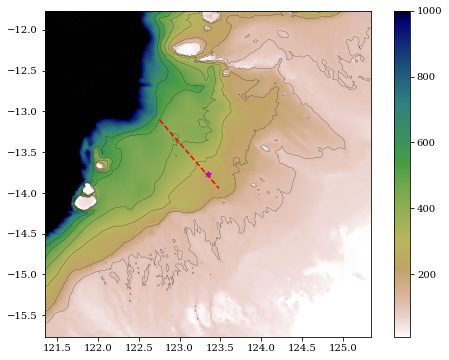

In [3]:
######
# Specify a start and end point and draw on a map

## WEL Bathy Prelude transect
x0 = 122.753
y0 = -13.1026

x1 = 123.486
y1 = -13.947

# Prelude point
xpt = 123.3506
ypt = -13.7641

dx = 0.01 # ~1km
######

## Generate x and y slice coordinates
lon = np.arange(x0, x1, dx)
Fx = interp1d([x0,x1],[y0,y1])
lat = Fx(lon)

plt.figure(figsize=(8,6))
ds.plotcelldata(ds._ds.dv, vmax=1000, cmap='gist_earth_r')
ds.contourf(ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.xlim(xpt-2, xpt+2)
plt.ylim(ypt-2, ypt+2)

In [89]:
# Interpolate the buoyancy frequency along the line

timept = np.array([
    np.datetime64('2014-03-30 00:00:00'),
    np.datetime64('2014-03-01 00:00:00'),
    np.datetime64('2013-08-01 00:00:00'),

    ])
Nz = 80

N2_z, zout = strat.predict_N2(N2file, lon ,lat, timept,  Nz)

# Calculate the internal wave parameters
phi_n, cn = iwaves.calc_modes(N2_z, zout)
alpha = iwaves.calc_alpha(phi_n, cn, zout)
beta = iwaves.calc_beta(phi_n, cn, zout)
ampratio = iwaves.ssh_to_amp_ratio(N2_z, phi_n, zout)
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)

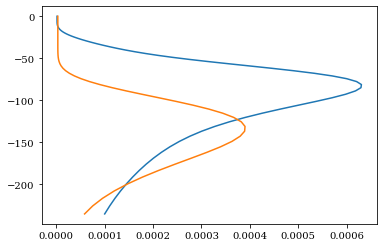

In [90]:
# Plot the buoyancy frequency at the first point in space
idx = 67
plt.figure()
plt.plot(N2_z[:,idx,0], -zout[:,idx,0],)
plt.plot(N2_z[:,idx,2], -zout[:,idx,2],)

(0, 30000.0)

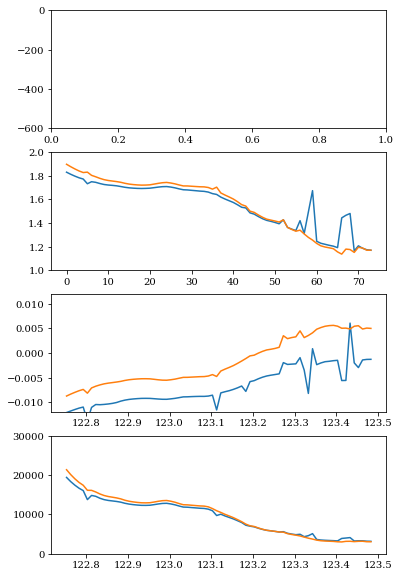

In [91]:
plt.figure(figsize=(6,10))
plt.subplot(411)
# plt.plot(lon, -hbathy)
plt.ylim(-600,0)

plt.subplot(412)
plt.plot(cn[:,0])
plt.plot(cn[:,2])

plt.ylim(1,2)

plt.subplot(413)
plt.plot(lon, alpha[:,0])
plt.plot(lon, alpha[:,2])

plt.ylim(-0.012, 0.012)

plt.subplot(414)
plt.plot(lon, beta[:,0])
plt.plot(lon, beta[:,2])
plt.ylim(0,3e4)

In [92]:
N2all = sshdriver.load_ssh_clim(N2file)
N2all._ds['N2_t'][tstep,:,idx].values

array([1.55420328e-06, 1.50494117e-04, 4.05599667e+00, 3.80388544e-01,
       4.50358433e+00, 1.12860952e+00])

In [93]:
# Indentify a trouble spot

ii = 68
cn[ii,0], lon[ii], lat[ii]

(1.479656905257041, 123.43300000000035, -13.88594515688989)

In [94]:
strat.fit_rho_lsq?

Signature: strat.fit_rho_lsq(rho, z, density_func, bounds, initguess)
Docstring:
Fits an analytical density/N^2 profile to data
Uses a robust linear regression
Inputs:
---
    rho: vector of density (or N^2) [Nz]
    z : depth [Nz] w/ negative values i.e. 0 at surface, positive: up
    density_func, bounds, initguess: 
Returns:
---
    rhofit: best fit function at z locations
    f0: tuple with analytical parameters
    err: L2-norm of the error vector
File:      ~/code/iwatlas/iwatlas/stratification.py
Type:      function


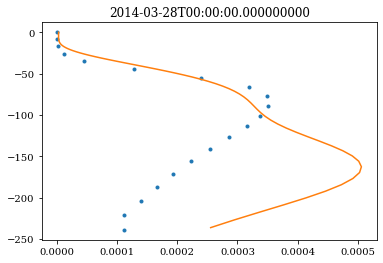

In [97]:
tstep =17
# _, idx = ds.find_nearest([ lon[ii], lat[ii]])
_, idx = ds.find_nearest([ xpt, ypt])

N2_ds = ds._ds['N2'][:,:,idx]

nz = N2_ds['Nk'].values
z = N2_ds['z_w'].values[0:nz]
N2 = N2_ds.values[tstep, 0:nz]

plt.figure()
plt.plot(N2,-z,'.')
plt.title(ds._ds['time'].values[tstep])
plt.plot(N2_z[:,ii,0], -zout[:,ii,0],)


[1.43788984e-06 2.20681019e-04 4.83245139e+00 7.04563923e-01
 4.25492841e+00 5.18601298e-01]


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


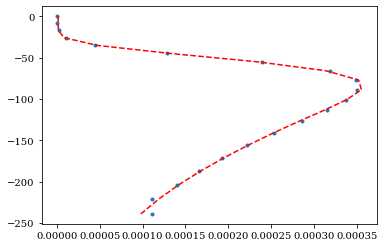

In [88]:
initguess = [1e-5,  1e-4, 4, 2, 4.5, 2]
# bounds = [ (1e-6, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 1e-1, 6, 6, 6, 6)]
bounds = [ (1e-6, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 2, 6, 6, 6, 6)]

zpr = -np.log(z)
zpr[0] = 0
N2std = 1# 2e-4

N2fit, N2params, err = strat.fit_rho_lsq(N2/N2std, zpr, strat.double_gaussian_N2,  bounds, initguess,)

plt.figure()
plt.plot(N2,-z,'.')
plt.plot(N2fit*N2std,-z,'r--')
print(N2params)


(-15.7641, -11.7641)

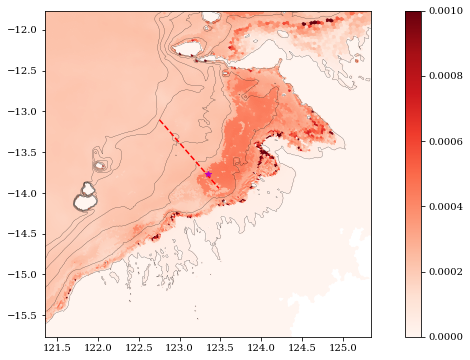

In [55]:
tstep = 0
# Plot the N2 parameterts
plt.figure(figsize=(12,6))
# N2all.plotcelldata(N2all._ds['N2_t'].values[tstep,0,:], cmap='Reds',vmax=1e-5)
N2all.plotcelldata(N2all._ds['N2_t'].values[tstep,1,:], cmap='Reds',vmax=1e-3)

ds.contourf(ds._ds.dv, [100,200,300,400,500,600], colors='k', linewidths=0.2, filled=False)
plt.plot(lon,lat,'r--')
plt.plot(xpt, ypt, 'm*')
plt.xlim(xpt-2, xpt+2)
plt.ylim(ypt-2, ypt+2)

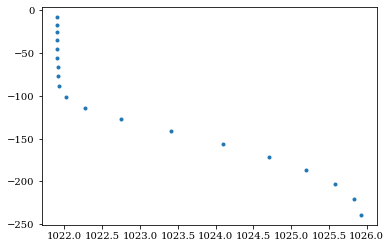

In [22]:
_, idx = clim.find_nearest([ lon[67], lat[67]])

rho_ds = clim._ds['rho'][:,:,idx]

nz = rho_ds['Nk'].values
dz = clim._ds['dz'].values[0:nz]
rho = rho_ds.values[0,0:nz]

z = np.cumsum(dz)
plt.figure()
plt.plot(rho,-z,'.')

In [53]:
rho_ds = clim._ds['rho'][:,:,idx]
rho_ds

<xarray.DataArray 'rho' (time: 23, Nk: 80)>
array([[1021.907477, 1021.902944, 1021.90168 , ...,         nan,         nan,
                nan],
       [1022.013249, 1022.009312, 1022.008469, ...,         nan,         nan,
                nan],
       [1021.998221, 1021.995141, 1021.995214, ...,         nan,         nan,
                nan],
       ...,
       [1021.642013, 1021.638858, 1021.638803, ...,         nan,         nan,
                nan],
       [1021.80614 , 1021.802342, 1021.801606, ...,         nan,         nan,
                nan],
       [1022.018715, 1022.014235, 1022.012969, ...,         nan,         nan,
                nan]])
Coordinates:
    xv       float64 ...
    yv       float64 ...
    Nk       int32 ...
  * time     (time) datetime64[ns] 2013-07-15T23:30:30 ... 2014-06-10T23:30:00
Attributes:
    long_name:    water density
    units:        kg m-3
    coordinates:  time z_r xv yv